# Recommender Systems 2019/20

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

In [2]:
from urllib.request import urlretrieve
import zipfile, os
import numpy as np

# If file exists, skip the download
data_file_path = "data/Movielens_10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)
    
dataFile = zipfile.ZipFile(data_file_name)
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path="data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)


In [3]:
def list_ID_stats(ID_list, label):
    
    min_val = min(ID_list)
    max_val = max(ID_list)
    unique_val = len(set(ID_list))
    missing_val = 1 - unique_val/(max_val - min_val)

    print("{} data, ID: min {}, max {}, unique {}, missig {:.2f} %".format(label, min_val, max_val, unique_val, missing_val*100))

    
    
list_ID_stats(userList, "User")
list_ID_stats(itemList, "Item")

User data, ID: min 1, max 71567, unique 69878, missig 2.36 %
Item data, ID: min 1, max 65133, unique 10677, missig 83.61 %


In [4]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()

### For items in particular most have no interactions. Do we have to remove them?

## YES!
#### Cold items have no impact in the evaluation, since they have no interactions
#### Moreover, considering how item-item and user-user CF are defined, they are not relevant.

In [5]:
warm_items_mask = np.ediff1d(URM_all.tocsc().indptr) > 0
warm_items = np.arange(URM_all.shape[1])[warm_items_mask]

URM_all = URM_all[:, warm_items]
URM_all

<71568x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

#### The same holds for users

In [6]:
warm_users_mask = np.ediff1d(URM_all.tocsr().indptr) > 0
warm_users = np.arange(URM_all.shape[0])[warm_users_mask]

URM_all = URM_all[warm_users, :]
URM_all

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

### Be careful! With this operation we lost the original mapping with item and user IDs!
### Keep the warm_items and warm_users array, we might need them in future...

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [7]:
from Notebooks_utils.data_splitter import train_test_holdout


URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)


from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python


# Item-based Collaborative Filtering

In [8]:
class ItemCFKNNRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [9]:
recommender = ItemCFKNNRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 5900 ( 55 % ), 195.28 column/sec, elapsed time 0.50 min
Similarity column 10677 ( 100 % ), 193.75 column/sec, elapsed time 0.92 min


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [10]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 485.85 usr/sec


## Remember to keep the URM in CSR format!

## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [11]:
x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemCFKNNRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])

Similarity column 6000 ( 56 % ), 197.43 column/sec, elapsed time 0.51 min
Similarity column 10677 ( 100 % ), 191.61 column/sec, elapsed time 0.93 min
Evaluated user 0 of 69878
Evaluated user 10000 of 69878
Evaluated user 20000 of 69878
Evaluated user 30000 of 69878
Evaluated user 40000 of 69878
Evaluated user 50000 of 69878
Evaluated user 60000 of 69878
Recommender performance is: Precision = 0.3420, Recall = 0.1110, MAP = 0.2711
Similarity column 5600 ( 52 % ), 183.90 column/sec, elapsed time 0.51 min
Similarity column 10677 ( 100 % ), 180.31 column/sec, elapsed time 0.99 min
Evaluated user 0 of 69878
Evaluated user 10000 of 69878
Evaluated user 20000 of 69878
Evaluated user 30000 of 69878
Evaluated user 40000 of 69878
Evaluated user 50000 of 69878
Evaluated user 60000 of 69878
Recommender performance is: Precision = 0.3647, Recall = 0.1155, MAP = 0.2966
Similarity column 5700 ( 53 % ), 186.92 column/sec, elapsed time 0.51 min
Similarity column 10677 ( 100 % ), 184.98 column/sec, elap

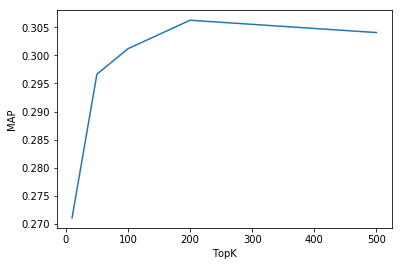

In [12]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors has a great impact on MAP.

#### Different datasets will behave in different ways.

### Shrinkage

In [13]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemCFKNNRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_shrinkage.append(result_dict["MAP"])

Similarity column 6200 ( 58 % ), 204.92 column/sec, elapsed time 0.50 min
Similarity column 10677 ( 100 % ), 205.43 column/sec, elapsed time 0.87 min
Evaluated user 0 of 69878
Evaluated user 10000 of 69878
Evaluated user 20000 of 69878
Evaluated user 30000 of 69878
Evaluated user 40000 of 69878
Evaluated user 50000 of 69878
Evaluated user 60000 of 69878
Recommender performance is: Precision = 0.3678, Recall = 0.1158, MAP = 0.3012
Similarity column 6200 ( 58 % ), 204.16 column/sec, elapsed time 0.51 min
Similarity column 10677 ( 100 % ), 204.44 column/sec, elapsed time 0.87 min
Evaluated user 0 of 69878
Evaluated user 10000 of 69878
Evaluated user 20000 of 69878
Evaluated user 30000 of 69878
Evaluated user 40000 of 69878
Evaluated user 50000 of 69878
Evaluated user 60000 of 69878
Recommender performance is: Precision = 0.3678, Recall = 0.1158, MAP = 0.3012
Similarity column 6200 ( 58 % ), 204.10 column/sec, elapsed time 0.51 min
Similarity column 10677 ( 100 % ), 204.92 column/sec, elap

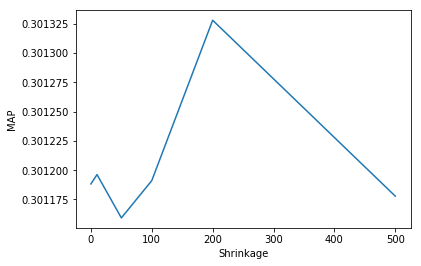

In [14]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) has no impact. Combine a parameter search with the two to ensure maximum recommendation quality

## REMINDER: Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# User-based Collaborative Filtering

In [15]:
class UserCFKNNRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        
        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [16]:
recommender = UserCFKNNRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10300 ( 15 % ), 343.19 column/sec, elapsed time 0.50 min
Similarity column 20600 ( 29 % ), 343.06 column/sec, elapsed time 1.00 min
Similarity column 30900 ( 44 % ), 343.04 column/sec, elapsed time 1.50 min
Similarity column 41200 ( 59 % ), 342.61 column/sec, elapsed time 2.00 min
Similarity column 51600 ( 74 % ), 343.07 column/sec, elapsed time 2.51 min
Similarity column 61900 ( 89 % ), 342.54 column/sec, elapsed time 3.01 min
Similarity column 69878 ( 100 % ), 340.76 column/sec, elapsed time 3.42 min


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [17]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 2580.72 usr/sec


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [18]:
x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = UserCFKNNRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])

Similarity column 10300 ( 15 % ), 343.05 column/sec, elapsed time 0.50 min
Similarity column 19800 ( 28 % ), 329.13 column/sec, elapsed time 1.00 min
Similarity column 25900 ( 37 % ), 287.05 column/sec, elapsed time 1.50 min
Similarity column 32200 ( 46 % ), 266.88 column/sec, elapsed time 2.01 min
Similarity column 40200 ( 58 % ), 266.48 column/sec, elapsed time 2.51 min
Similarity column 49100 ( 70 % ), 270.27 column/sec, elapsed time 3.03 min
Similarity column 56400 ( 81 % ), 266.11 column/sec, elapsed time 3.53 min
Similarity column 66700 ( 95 % ), 275.56 column/sec, elapsed time 4.03 min
Similarity column 69878 ( 100 % ), 277.78 column/sec, elapsed time 4.19 min
Evaluated user 0 of 69878
Evaluated user 10000 of 69878
Evaluated user 20000 of 69878
Evaluated user 30000 of 69878
Evaluated user 40000 of 69878
Evaluated user 50000 of 69878
Evaluated user 60000 of 69878
Recommender performance is: Precision = 0.2487, Recall = 0.0868, MAP = 0.1968
Similarity column 10200 ( 15 % ), 337.30

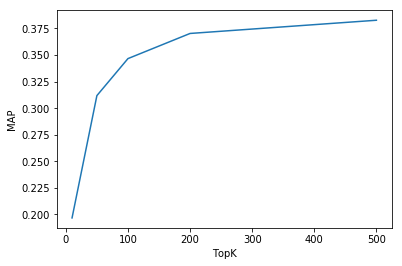

In [19]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [20]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = UserCFKNNRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_shrinkage.append(result_dict["MAP"])

Similarity column 8900 ( 13 % ), 296.64 column/sec, elapsed time 0.50 min
Similarity column 16800 ( 24 % ), 279.41 column/sec, elapsed time 1.00 min
Similarity column 25300 ( 36 % ), 280.27 column/sec, elapsed time 1.50 min
Similarity column 33800 ( 48 % ), 281.01 column/sec, elapsed time 2.00 min
Similarity column 42200 ( 60 % ), 280.17 column/sec, elapsed time 2.51 min
Similarity column 50800 ( 73 % ), 280.87 column/sec, elapsed time 3.01 min
Similarity column 58000 ( 83 % ), 274.66 column/sec, elapsed time 3.52 min
Similarity column 66200 ( 95 % ), 274.47 column/sec, elapsed time 4.02 min
Similarity column 69878 ( 100 % ), 273.01 column/sec, elapsed time 4.27 min
Evaluated user 0 of 69878
Evaluated user 10000 of 69878
Evaluated user 20000 of 69878
Evaluated user 30000 of 69878
Evaluated user 40000 of 69878
Evaluated user 50000 of 69878
Evaluated user 60000 of 69878
Recommender performance is: Precision = 0.4115, Recall = 0.1424, MAP = 0.3466
Similarity column 5000 (  7 % ), 165.79 c

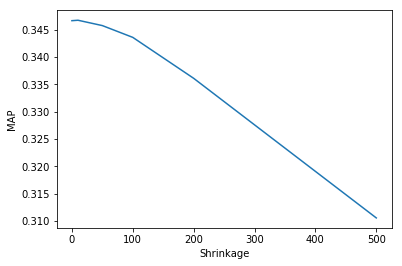

In [21]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

## And now load the content information:

In [22]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)


In [23]:
list_ID_stats(userList_icm, "Users ICM")
list_ID_stats(itemList_icm, "Items ICM")

Users ICM data, ID: min 15, max 71556, unique 4009, missig 94.40 %
Items ICM data, ID: min 1, max 65130, unique 7601, missig 88.33 %


### The numbers of items and users in the ICM matrix is different from what we saw in the URM, why?

### The tags are string, we should traslate them into numbers so we can use them as indices in the ICM

In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

print(tagList_icm[0:10])

[ 9814 13375 14131  8515 10769 14070  7015  8071 14829 14900]


# We can now build the ICM

#### Be careful with the indices!

In [25]:
import numpy as np

n_items = len(warm_items_mask)
n_tags = max(tagList_icm) + 1

ICM_shape = (n_items, n_tags)

ones = np.ones(len(tagList_icm))
ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape = ICM_shape)
ICM_all = ICM_all.tocsr()

ICM_all

<65134x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

## Remember the mapping of the URM? It is not the same of the ICM one anymore!
## We have to keep only the warm items also in the ICM

In [26]:
ICM_all = ICM_all[warm_items, :]
ICM_all = ICM_all.tocsr()

ICM_all

<10677x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71125 stored elements in Compressed Sparse Row format>

## We can also remove the features that have no occurencies anymore

In [27]:
warm_features_mask = np.ediff1d(ICM_all.tocsc().indptr) > 0
warm_features = np.arange(ICM_all.shape[1])[warm_features_mask]
# Don't forget to keep the mapping

ICM_all = ICM_all[:, warm_features]
ICM_all = ICM_all.tocsr()

ICM_all

<10677x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71125 stored elements in Compressed Sparse Row format>

## We could have items without features...

In [28]:
nofeatures_items_mask = np.ediff1d(ICM_all.tocsr().indptr) <= 0
nofeatures_items_mask.sum()

3080

## We might not remove them in some cases, but we will do it for our comparison

In [29]:
warm_items_mask_2 = np.ediff1d(ICM_all.tocsr().indptr) > 0
warm_items_2 = np.arange(ICM_all.shape[0])[warm_items_mask_2]

ICM_all = ICM_all[warm_items_2, :]
ICM_all = ICM_all.tocsr()

ICM_all

<7597x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71125 stored elements in Compressed Sparse Row format>

## Now we have to remove these items also from the URM and the cold users consequently

In [30]:
URM_all = URM_all[:, warm_items_2]
URM_all = URM_all.tocsr()

warm_users_mask_2 = np.ediff1d(URM_all.tocsr().indptr) > 0
warm_users_2 = np.arange(URM_all.shape[0])[warm_users_mask_2]

URM_all = URM_all[warm_users_2, :]
URM_all = URM_all.tocsr()

URM_all

<69878x7597 sparse matrix of type '<class 'numpy.float64'>'
	with 9708495 stored elements in Compressed Sparse Row format>

## Split the new URM for train and test

In [31]:
from Notebooks_utils.data_splitter import train_test_holdout


URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)


from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

## We are finally ready for the comparison

### Rewrite the content-based recommender

In [32]:
class ItemCBFKNNRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [33]:
content_recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
collaborative_recommender = ItemCFKNNRecommender(URM_train)

for topK in [50, 100, 200]:
    for shrink in [10, 50, 100]:
        content_recommender.fit(shrink=shrink, topK=topK)
        collaborative_recommender.fit(shrink=shrink, topK=topK)
        
        result_dict = evaluate_algorithm(URM_test, content_recommender)
        MAP_per_k.append(result_dict["MAP"])
        
        result_dict = evaluate_algorithm(URM_test, collaborative_recommender)
        MAP_per_k.append(result_dict["MAP"])

Similarity column 7597 ( 100 % ), 4318.96 column/sec, elapsed time 0.03 min
Similarity column 5700 ( 75 % ), 189.12 column/sec, elapsed time 0.50 min
Similarity column 7597 ( 100 % ), 189.06 column/sec, elapsed time 0.67 min
Evaluated user 0 of 69878
Evaluated user 10000 of 69878
Evaluated user 20000 of 69878
Evaluated user 30000 of 69878
Evaluated user 40000 of 69878
Evaluated user 50000 of 69878
Evaluated user 60000 of 69878
Recommender performance is: Precision = 0.1159, Recall = 0.0252, MAP = 0.0836
Evaluated user 0 of 69878
Evaluated user 10000 of 69878
Evaluated user 20000 of 69878
Evaluated user 30000 of 69878
Evaluated user 40000 of 69878
Evaluated user 50000 of 69878
Evaluated user 60000 of 69878
Recommender performance is: Precision = 0.3647, Recall = 0.1178, MAP = 0.2968
Similarity column 7597 ( 100 % ), 4442.76 column/sec, elapsed time 0.03 min
Similarity column 5400 ( 71 % ), 176.87 column/sec, elapsed time 0.51 min
Similarity column 7597 ( 100 % ), 177.08 column/sec, elap

## Collaborative is outperforming content-based by a large margin, as we could expect

### Let's try to see how the recommendations are distributed

Recommended to user 0/69878
Recommended to user 10000/69878
Recommended to user 20000/69878
Recommended to user 30000/69878
Recommended to user 40000/69878
Recommended to user 50000/69878
Recommended to user 60000/69878


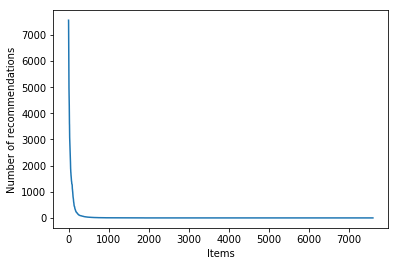

In [34]:
x_tick = np.arange(URM_all.shape[1])
counter = np.zeros(URM_all.shape[1])
for user_id in range(URM_all.shape[0]):
    recs = collaborative_recommender.recommend(user_id, at=5)
    counter[recs] += 1
    if user_id % 10000 == 0:
        print("Recommended to user {}/{}".format(user_id, URM_all.shape[0]))

pyplot.plot(x_tick, np.sort(counter)[::-1])
pyplot.ylabel('Number of recommendations')
pyplot.xlabel('Items')
pyplot.show()

Recommended to user 0/69878
Recommended to user 10000/69878
Recommended to user 20000/69878
Recommended to user 30000/69878
Recommended to user 40000/69878
Recommended to user 50000/69878
Recommended to user 60000/69878


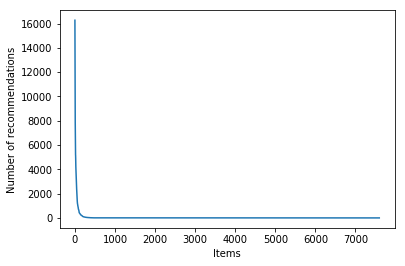

In [35]:
x_tick = np.arange(URM_all.shape[1])
counter = np.zeros(URM_all.shape[1])
for user_id in range(URM_all.shape[0]):
    recs = content_recommender.recommend(user_id, at=5)
    counter[recs] += 1
    if user_id % 10000 == 0:
        print("Recommended to user {}/{}".format(user_id, URM_all.shape[0]))

pyplot.plot(x_tick, np.sort(counter)[::-1])
pyplot.ylabel('Number of recommendations')
pyplot.xlabel('Items')
pyplot.show()

## Really unexpected!
* Configuration
* User tags